# 模板

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler


import torchvision
from torchvision import transforms
import os

from lxml import etree # 解析xml
from matplotlib.patches import Rectangle  # 绘制矩形
import glob

from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 图像定位
The Oxford-IIIT Pet Dataset是一个宠物图像数据集,包含37种宠物,每种宠物200张左右宠物图片,该数据集同时包含宠物分类、头部轮廊标注和语义分割信息。

## 数据预处理

In [23]:
images = glob.glob(r'data/Oxford-IIIT Pets Dataset/images/*.jpg')  # 7390
xmls = glob.glob(r"data/Oxford-IIIT Pets Dataset/annotations/xmls/*.xml")  # 部分有标记 3686
xmls_names = [x.split('\\')[-1].split('.xml')[0] for x in xmls]  # 所有有标记的图片名称
imgs = [img for img in images if img.split('\\')[-1].split('.jpg')[0] in xmls_names]  # 找到有标记的图片路径
# imgs,xmls 都是一一对应的，不需要排序

def to_labels(path):
    """从xml中读取标记的矩形框，返回比例值"""
    xml = open(r'{}'.format(path)).read()
    sel = etree.HTML(xml)  # 选择器
    width = int(sel.xpath('//size/width/text()')[0])
    height = int(sel.xpath('//size/height/text()')[0])
    xmin = int(sel.xpath('//bndbox/xmin/text()')[0])
    ymin = int(sel.xpath('//bndbox/ymin/text()')[0])
    xmax = int(sel.xpath('//bndbox/xmax/text()')[0])
    ymax = int(sel.xpath('//bndbox/ymax/text()')[0])
    return [xmin/width, ymin/height, xmax/width, ymax/height]
labels = [to_labels(path) for path in xmls]  # 将xml内矩形提取出来转为label，比例表示

index = np.random.permutation(len(imgs))  # 打乱并划分训练集和测试集
imgs = np.array(imgs)[index]
labels = np.array(labels)[index].astype(np.float32)
s = int(len(imgs)*0.8)
train_imgs, train_labels = imgs[:s], labels[:s]
test_imgs, test_labels = imgs[s:], labels[s:]

# 创建DataSet
transform = transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor()
])
class OxfordDataset(Dataset):
    def __init__(self, img_paths, labels_list ,transform):
        self.imgs = img_paths  # 路径列表
        self.labels = labels_list
        self.transforms = transform
    def __getitem__(self, index):
        """返回img和对应的矩形框(比例表示)"""
        """ BUG：stack expects each tensor to be equal size, but got [1, 224, 224] at entry 0 and [3, 224, 224] at entry 1
            MD居然是文件中有一张黑白图片，解决方法：Image.open(self.imgs[index]).convert("RGB") 全部以RGB方式读取 """
        img_tensor = self.transforms(Image.open(self.imgs[index]).convert("RGB"))
        xmin, ymin, xmax, ymax = (self.labels[index][i] for i in range(4))
        return img_tensor, xmin, ymin, xmax, ymax
    def __len__(self):
        return len(self.imgs)

train_ds = OxfordDataset(train_imgs, train_labels, transform)
test_ds = OxfordDataset(test_imgs, test_labels, transform)
BATCHSIZE=8
train_dl = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE)

### 显示图片 show_img

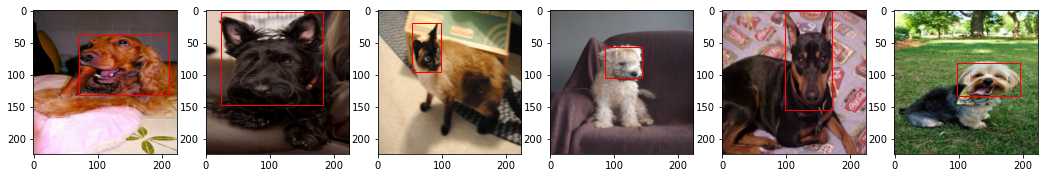

In [25]:
def show_img(dataloader, size=3, transform_size=224):
    """
    显示前6张图片
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    imgs, xmin, ymin, xmax, ymax = next(iter(dataloader))
    s = 6  # 显示前几个图片
    plt.figure(figsize=(s*size, 1*size))
    for i, (img, x1, y1, x2, y2) in enumerate(zip(imgs[:s], xmin[:s], ymin[:s], xmax[:s], ymax[:s])):
        img = img.permute(1, 2, 0).numpy()  # 改变维度 toTensor的逆操作
        # img = (img+1)/2 # 从(-1,1)转化到(0,1)  标准化的逆操作
        plt.subplot(1, 6, i+1)  # 子图
        plt.imshow(img)  # 显示图片
        x1, y1, x2, y2 = [i*transform_size for i in [x1, y1, x2, y2]]  # 转为实际的宽和高
        rect = Rectangle((x1, y1), (x2-x1), (y2-y1), fill=False, color='red')  # 矩形框坐标
        ax = plt.gca()  # 获取当前坐标系
        ax.axes.add_patch(rect)  # 绘制矩形
show_img(train_dl)  # 看看长啥样

## 创建定位模型

In [26]:
resnet = torchvision.models.resnet101(pretrained=True)  # avgpool前的都需要
in_size = resnet.fc.in_features  # 卷积基最后的输出2048
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_base = nn.Sequential(*list(resnet.children())[:-1])  # 提取卷积基
        self.fc1 = nn.Linear(in_size, 1)  # 输出4个值，代表相对位置xmin, ymin, xmax, ymax
        self.fc2 = nn.Linear(in_size, 1)
        self.fc3 = nn.Linear(in_size, 1)
        self.fc4 = nn.Linear(in_size, 1)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(x.size(0), -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        return x1, x2, x3, x4

model = Net()
torch.cuda.empty_cache()  # 清空一下，否则会爆显存
model.to(device)

Net(
  (conv_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 25

## 训练模型

### 训练 fit
4个输出 xmin, ymin, xmax, ymax

In [5]:
def fit(epoch, model, trainloader, testloader):
    """输入模型、输入数据(train_dl, test_dl)， 对数据输入在模型上训练，并返回loss变化"""
    running_loss = 0
    model.train()  # 训练模式 dropout BN发挥作用
    for img, x1, y1, x2, y2 in trainloader:  # 对应xmin, ymin, xmax, ymax
        var = (print(i.shape) for i in [img, x1, y1, x2, y2])
        img = img.to(device)
        y = (i.to(device) for i in [x1, y1, x2, y2])
        y_pred = model(img)
        l1, l2, l3, l4 = (loss_fn(i_pred, i) for i, i_pred in zip(y, y_pred))
        loss = l1+l2+l3+l4
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            running_loss += loss.item()

    lr_decay.step()  # 学习率衰减
    epoch_loss = running_loss / len(trainloader.dataset)  # 平均loss

    test_running_loss = 0
    model.eval()  # 预测模式 dropout BN不发挥作用
    with torch.no_grad():
        for img, x1, y1, x2, y2 in testloader:
            img = img.to(device)
            y = (i.to(device) for i in [x1, y1, x2, y2])
            y_pred = model(img)
            l1, l2, l3, l4 = (loss_fn(i_pred, i) for i, i_pred in zip(y, y_pred))
            loss = l1+l2+l3+l4
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)

    print('epoch:', epoch,
          'loss:', round(epoch_loss, 3),
          'test_loss:', round(epoch_test_loss, 3),
             )

    return epoch_loss, epoch_test_loss

cuda:0


### 显示损失 show_loss
回归问题，没有必要计算准确率

In [28]:
def show_loss(train_loss, test_loss):
    plt.figure()
    plt.plot(range(1, epochs+1), train_loss, 'r', label='train_loss')
    plt.plot(range(1, epochs+1), test_loss, 'bo', label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()
    plt.show()

### 开始训练

E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
E:\Anaconda3\envs\pytorch-gpu\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return

epoch: 0 loss: 0.016 test_loss: 0.011
epoch: 1 loss: 0.012 test_loss: 0.011
epoch: 2 loss: 0.011 test_loss: 0.011
epoch: 3 loss: 0.011 test_loss: 0.012
epoch: 4 loss: 0.01 test_loss: 0.011


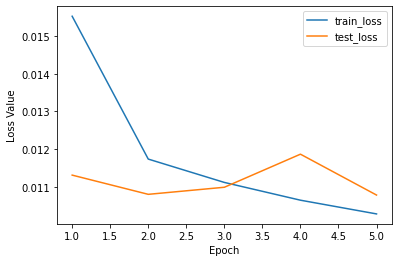

In [27]:
# 损失函数和优化器
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

# 开始训练 (模型太复杂，小GPU吃不消)
epochs = 5
train_loss = []
test_loss = []
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

show_loss(train_loss, test_loss)

## 模型保存与预测

In [30]:
PATH = 'model/Oxford.pth'
torch.save(model.state_dict(), PATH)

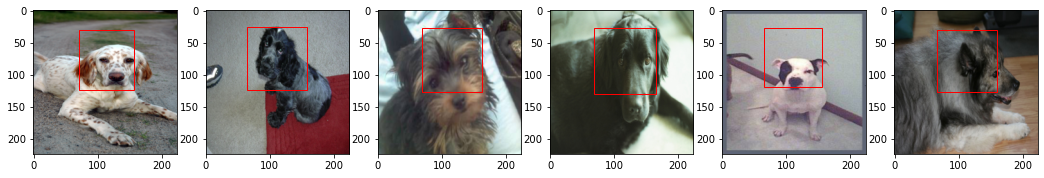

In [32]:
# 预测模型
plt.figure(figsize=(18, 3))
imgs, _, _, _, _ = next(iter(test_dl))
imgs = imgs.to(device)
out1, out2, out3, out4 = model(imgs)
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(imgs[i].permute(1,2,0).cpu().numpy())
    xmin, ymin, xmax, ymax = (out[i].item()*224 for out in [out1, out2, out3, out4])
    rect = Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), fill=False, color='red')
    ax = plt.gca()
    ax.axes.add_patch(rect)

# Unet图像语义分割
unet-people数据集是对应的人物和蒙版信息；
## 数据预处理

In [17]:
all_pics = glob.glob(r'data\unet-people\training\*.png')
images = [p for p in all_pics if 'matte' not in p]  #  训练图片路径 1700张
annotations = [p for p in all_pics if 'matte' in p]  # 对应分割图/注释路径
np.random.seed(2022)
index = np.random.permutation(len(images))  # 乱序
images = np.array(images)[index][:200]  # 数据太大，先拿200张试试
anno = np.array(annotations)[index][:200]

all_test_pics = glob.glob(r'data\unet-people\testing\*.png')
test_images = [p for p in all_pics if 'matte' not in p][:200]  # 测试图片路径
test_anno = [p for p in all_pics if 'matte' in p][:200]  # 对应分割图路径

# 创建数据集
class PortraitDataset(Dataset):
    def __init__(self, img_paths, anno_paths):
        self.imgs = img_paths
        self.annos = anno_paths
        self.transform =transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        img = self.imgs[index]
        anno = self.annos[index]
        img_tensor = self.transform(Image.open(img).convert("RGB"))  # 读取的是RGB彩色图
        anno_tensor = self.transform(Image.open(anno).convert("L"))  # 读取的是灰度图
        # 将分割图从0~255划分为2类，不是0就是1
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)
        anno_tensor[anno_tensor > 0] = 1

        return img_tensor, anno_tensor

    def __len__(self):
        return len(self.imgs)

BATCHSIZE = 8
train_dl = DataLoader(PortraitDataset(images, anno), batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(PortraitDataset(test_images, test_anno), batch_size=BATCHSIZE)

### 显示图片 show_img

In [18]:
def show_img(dataloader, size=3, transform_size=256):
    """
    显示前6张图片
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    imgs, annos = next(iter(dataloader))
    s = 6  # 显示前几个图片
    plt.figure(figsize=(s*size, 2*size))
    for i, (img, anno) in enumerate(zip(imgs[:s], annos[:s])):
        img = img.permute(1, 2, 0).numpy()  # 改变维度 toTensor的逆操作
        anno = anno.numpy()
        plt.subplot(2, 6, i+1)  # 子图
        plt.imshow(img)  # 显示图片
        plt.subplot(2, 6, i+7)
        plt.imshow(anno)

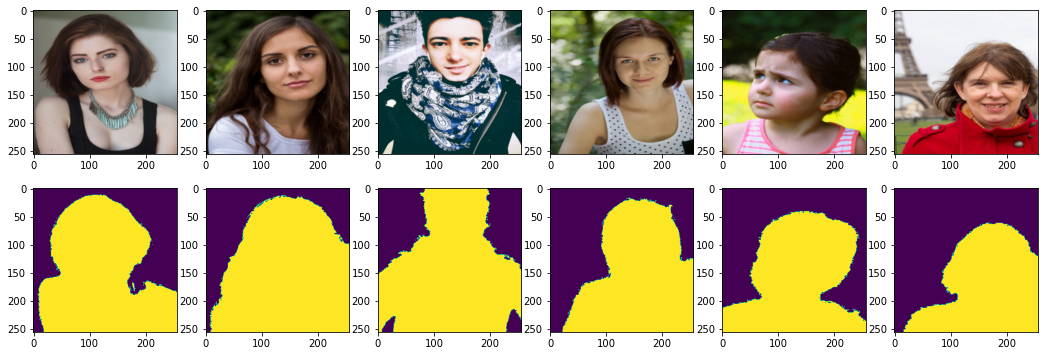

In [19]:
show_img(train_dl)

## 创建Unet模型

In [3]:
class Downsample(nn.Module):
    """下采样模型"""
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # 保持图像不变
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x, is_pool=True):
        if is_pool:  # 是否下采样：最大池化
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

class Upsample(nn.Module):
    """上采样模型"""
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(2*channels, channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(channels, channels,  kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.upconv_relu = nn.Sequential(
                               nn.ConvTranspose2d(channels, channels//2, kernel_size=3,  # 反卷积
                                                  stride=2,  # 长宽变为原来的2倍
                                                  padding=1,  # 从第一个像素开始做反卷积，## TODO
                                                  output_padding=1),  # 反卷积之后在最外层做填充
                               nn.ReLU(inplace=True) )

    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)  # 上采样
        return x

class UNet(nn.Module):
    """实现Unet模型"""
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        self.up = nn.Sequential(
                               nn.ConvTranspose2d(1024, 512, kernel_size=3,
                                                  stride=2, padding=1, output_padding=1),
                               nn.ReLU(inplace=True)
            )
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)

        self.conv_2 = Downsample(128, 64)
        self.last = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x5 = self.up(x5)
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024 沿着channel进行合并
        x5 = self.up1(x5)                         # 64*64*256
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        x5 = self.last(x5)                        # 256*256*3
        return x5

In [4]:
model = UNet()
torch.cuda.empty_cache()  # 清空一下，否则会爆显存
model.to(device)

UNet(
  (down1): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=Tr

## 训练模型

### 训练 fit

In [19]:
def fit(epoch, model, trainloader, testloader):
    correct = 0
    total = 0
    running_loss = 0

    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()
    lr_decay.step()
    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / (total*256*256)

    test_correct = 0
    test_total = 0
    test_running_loss = 0

    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y).sum().item()
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)
    epoch_test_acc = test_correct / (test_total*256*256)


    print('epoch: ', epoch,
          'loss： ', round(epoch_loss, 3),
          'accuracy:', round(epoch_acc, 3),
          'test_loss： ', round(epoch_test_loss, 3),
          'test_accuracy:', round(epoch_test_acc, 3)
             )

    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

### 开始训练

In [8]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)

epochs = 10
train_loss, train_acc, test_loss, test_acc = [], [], [], []
for epoch in range(epochs):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  0 loss：  0.085 accuracy: 0.585 test_loss：  0.09 test_accuracy: 0.443
epoch:  1 loss：  0.079 accuracy: 0.625 test_loss：  0.084 test_accuracy: 0.565
epoch:  2 loss：  0.074 accuracy: 0.692 test_loss：  0.063 test_accuracy: 0.796
epoch:  3 loss：  0.073 accuracy: 0.709 test_loss：  0.071 test_accuracy: 0.755
epoch:  4 loss：  0.096 accuracy: 0.626 test_loss：  0.086 test_accuracy: 0.462
epoch:  5 loss：  0.081 accuracy: 0.597 test_loss：  0.076 test_accuracy: 0.696
epoch:  6 loss：  0.071 accuracy: 0.712 test_loss：  0.061 test_accuracy: 0.791
epoch:  7 loss：  0.068 accuracy: 0.736 test_loss：  0.06 test_accuracy: 0.795
epoch:  8 loss：  0.067 accuracy: 0.742 test_loss：  0.061 test_accuracy: 0.773
epoch:  9 loss：  0.066 accuracy: 0.739 test_loss：  0.059 test_accuracy: 0.794


## 模型保存和测试

In [4]:
PATH = 'model/unet_people.pth'
# torch.save(model.state_dict(), PATH)
my_model = UNet()
my_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
def show_img(dataloader, size=3, transform_size=256):
    """
    显示前6张图片，预测分布图，实际分布图
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    imgs, annos = next(iter(dataloader))
    s = 6  # 显示前几个图片
    preds = my_model(imgs)  # 预测图片
    plt.figure(figsize=(s*size, 3*size))
    for i, (img, pred, anno) in enumerate(zip(imgs[:s], preds[:s] ,annos[:s])):
        plt.subplot(3, 6, i+1)  # 子图
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())  # 显示图片  # 改变维度 toTensor的逆操作
        plt.subplot(3, 6, i+7)  # 预测图
        plt.imshow(torch.argmax(pred.permute(1, 2, 0), axis=-1).detach().numpy())
        plt.subplot(3, 6, i+13)  # 实际分布图
        plt.imshow(anno.cpu().numpy())

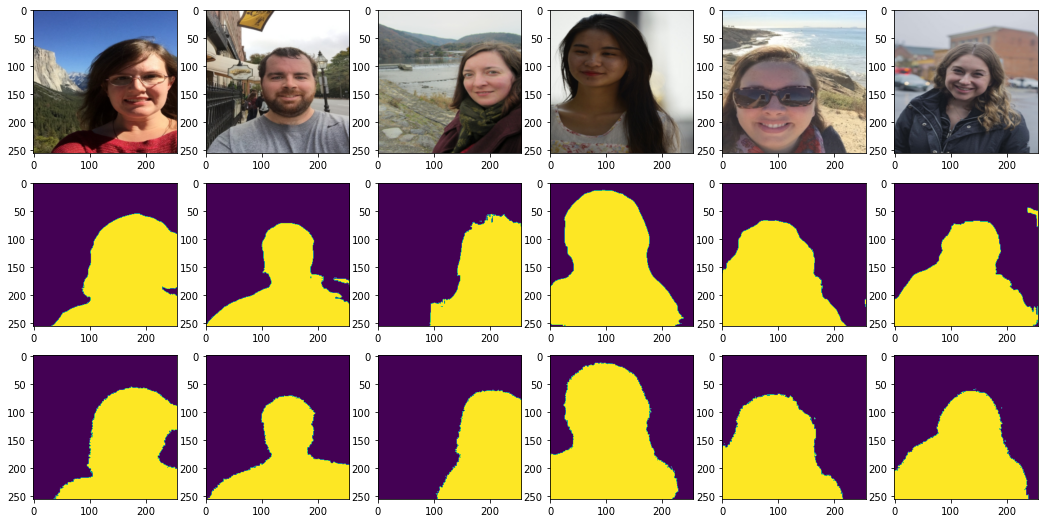

In [16]:
show_img(test_dl)

# Unet图像去噪

## 数据预处理

In [8]:
rain_path = glob.glob(r'data\unet_rain\rain\*.png')
no_rain_path = glob.glob(r'data\unet_rain\norain\*.png')
rain_path = rain_path[:1600]
no_rain_path = no_rain_path[:1600]
test_rain_path = rain_path[-200:]
test_no_rain_path = no_rain_path[-200:]
# 创建数据集
class PortraitDataset(Dataset):
    def __init__(self, rain_path, no_rain_path):
        self.rains = rain_path
        self.no_rains = no_rain_path
        self.transform =transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        rain = self.rains[index]
        no_rain = self.no_rains[index]
        rain_tensor = self.transform(Image.open(rain).convert("RGB"))
        no_rain_tensor = self.transform(Image.open(no_rain).convert("RGB"))
        return rain_tensor, no_rain_tensor

    def __len__(self):
        return len(self.rains)

BATCHSIZE = 8
train_dl = DataLoader(PortraitDataset(rain_path, no_rain_path), batch_size=BATCHSIZE, shuffle=True)
test_dl = DataLoader(PortraitDataset(test_rain_path, test_no_rain_path), batch_size=BATCHSIZE)

In [3]:
def show_img(dataloader, size=3, transform_size=256):
    """
    显示前6张图片
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    rains, no_rains = next(iter(dataloader))
    s = 6  # 显示前几个图片
    plt.figure(figsize=(s*size, 2*size))
    for i, (rain, no_rain) in enumerate(zip(rains[:s], no_rains[:s])):
        rain = rain.permute(1, 2, 0).numpy()  # 改变维度 toTensor的逆操作
        no_rain = no_rain.permute(1, 2, 0).numpy()
        plt.subplot(2, 6, i+1)  # 子图
        plt.imshow(rain)  # 显示图片
        plt.subplot(2, 6, i+7)
        plt.imshow(no_rain)

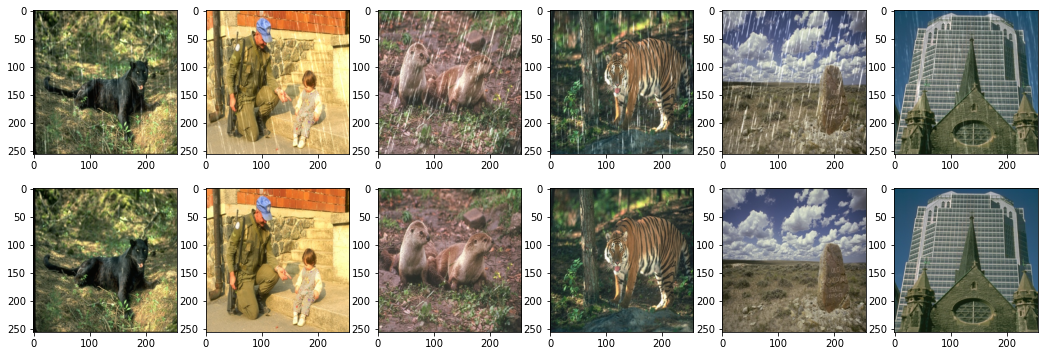

In [10]:
show_img(train_dl)

## 创建Unet模型

In [3]:
class Downsample(nn.Module):
    """下采样模型"""
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), # 保持图像不变
                            nn.ReLU(inplace=True),
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.pool = nn.MaxPool2d(kernel_size=2)
    def forward(self, x, is_pool=True):
        if is_pool:  # 是否下采样：最大池化
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

class Upsample(nn.Module):
    """上采样模型"""
    def __init__(self, channels):
        super(Upsample, self).__init__()
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(2*channels, channels, kernel_size=3, padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(channels, channels,  kernel_size=3, padding=1),
                            nn.ReLU(inplace=True)
            )
        self.upconv_relu = nn.Sequential(
                               nn.ConvTranspose2d(channels, channels//2, kernel_size=3,  # 反卷积
                                                  stride=2,  # 长宽变为原来的2倍
                                                  padding=1,  # 从第一个像素开始做反卷积，## TODO
                                                  output_padding=1),  # 反卷积之后在最外层做填充
                               nn.ReLU(inplace=True) )

    def forward(self, x):
        x = self.conv_relu(x)
        x = self.upconv_relu(x)  # 上采样
        return x

class UNet(nn.Module):
    """实现Unet模型"""
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = Downsample(3, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 1024)
        self.up = nn.Sequential(
                               nn.ConvTranspose2d(1024, 512, kernel_size=3,
                                                  stride=2, padding=1, output_padding=1),
                               nn.ReLU(inplace=True)
            )
        self.up1 = Upsample(512)
        self.up2 = Upsample(256)
        self.up3 = Upsample(128)

        self.conv_2 = Downsample(128, 64)
        self.last = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x, is_pool=False)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x5 = self.down5(x4)
        x5 = self.up(x5)
        x5 = torch.cat([x4, x5], dim=1)           # 32*32*1024 沿着channel进行合并
        x5 = self.up1(x5)                         # 64*64*256
        x5 = torch.cat([x3, x5], dim=1)           # 64*64*512
        x5 = self.up2(x5)                         # 128*128*128
        x5 = torch.cat([x2, x5], dim=1)           # 128*128*256
        x5 = self.up3(x5)                         # 256*256*64
        x5 = torch.cat([x1, x5], dim=1)           # 256*256*128
        x5 = self.conv_2(x5, is_pool=False)       # 256*256*64
        x5 = self.last(x5)                        # 256*256*3
        return x5

In [5]:
model = UNet()
torch.cuda.empty_cache()  # 清空一下，否则会爆显存
model.to(device)

UNet(
  (down1): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down3): Downsample(
    (conv_relu): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=Tr

## 训练模型

In [10]:
# loss_fn = nn.CrossEntropyLoss()  # 效果很垃圾
loss_fn = nn.HuberLoss()  # 效果很好
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_decay = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1)
def fit(epoch, model, trainloader, testloader):
    total = 0
    running_loss = 0

    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()

    lr_decay.step()
    epoch_loss = running_loss / len(trainloader.dataset)

    test_total = 0
    test_running_loss = 0

    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()

    epoch_test_loss = test_running_loss / len(testloader.dataset)


    print('epoch: ', epoch,
          'loss： ', round(epoch_loss, 6),
          'test_loss： ', round(epoch_test_loss, 6)
             )

    return epoch_loss, epoch_test_loss

In [7]:
epochs = 5
train_loss, test_loss = [], []
for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch, model, train_dl, test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

epoch:  0 loss：  0.009 test_loss：  0.0
epoch:  1 loss：  0.0 test_loss：  0.0
epoch:  2 loss：  0.0 test_loss：  0.0
epoch:  3 loss：  0.0 test_loss：  0.0
epoch:  4 loss：  0.0 test_loss：  0.0


## 模型保存与测试

In [4]:
PATH = 'model/unet_rain.pth'

In [9]:
torch.save(model.state_dict(), PATH)

In [5]:
model = UNet()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
model.cpu()
def show_img(dataloader, size=3, transform_size=256):
    """
    显示前6张图片，预测分布图，实际分布图
    :param size: 每张图片显示大小
    :param transform_size: transform中resize的大小
    """
    rains, no_rains = next(iter(dataloader))
    s = 6  # 显示前几个图片
    preds = model(rains)  # 预测图片
    plt.figure(figsize=(s*size, 3*size))
    for i, (rain, pred, no_rain) in enumerate(zip(rains[:s], preds[:s] ,no_rains[:s])):
        plt.subplot(3, 6, i+1)  # 子图
        plt.imshow(rain.permute(1, 2, 0).cpu().numpy())  # 显示图片  # 改变维度 toTensor的逆操作
        plt.subplot(3, 6, i+7)  # 预测图
        plt.imshow(pred.permute(1, 2, 0).detach().numpy())
        plt.subplot(3, 6, i+13)  # 实际分布图
        plt.imshow(no_rain.permute(1, 2, 0).cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


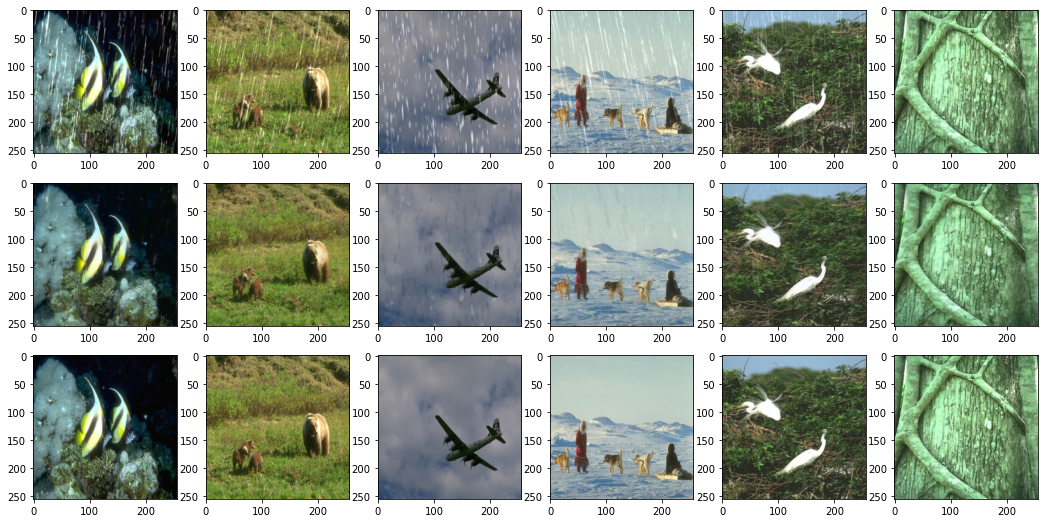

In [9]:
show_img(test_dl)